In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler

C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

data = pd.read_excel("C:/Users/ucbab/OneDrive/Documents/Pasc-Data.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temperature      30 non-null     int64  
 1   Catalyst dosage  30 non-null     int64  
 2   MeOH-Oil ratio   30 non-null     int64  
 3   Time             30 non-null     float64
 4   Biodiesel yield  30 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.3 KB


In [4]:
data.describe()

,Temperature,Catalyst dosage,MeOH-Oil ratio,Time,Biodiesel yield
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,70.000000,3.000000,18.000000,2.252667,60.441113
std,9.097177,0.909718,5.458306,0.796007,20.163650
min,50.000000,1.000000,6.000000,0.500000,20.590000
25%,60.000000,2.000000,12.000000,1.380000,42.821250
50%,70.000000,3.000000,18.000000,2.250000,63.134850
75%,80.000000,4.000000,24.000000,3.130000,75.497500
max,90.000000,5.000000,30.000000,4.000000,95.350000


<Axes: >

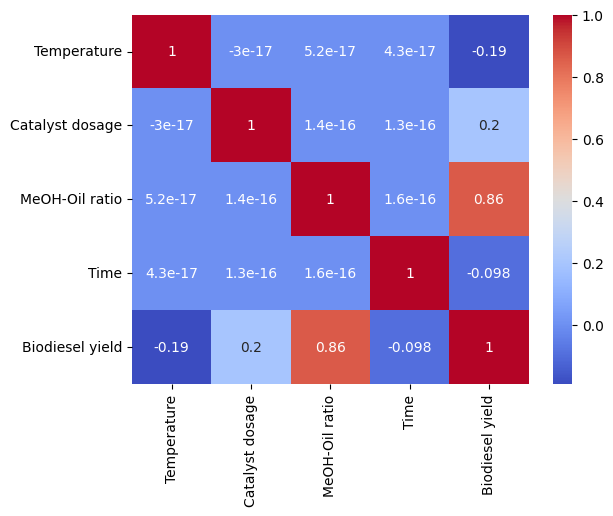

In [5]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [6]:
x= data.drop(columns=['Biodiesel yield']).values
y=data['Biodiesel yield'].values

In [7]:
scaler_x = StandardScaler()
scaler_y= StandardScaler()
x = scaler_x.fit_transform(x)
y=scaler_y.fit_transform(y.reshape(-1,1))


In [8]:
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)


In [ ]:
best_score = -np.inf

def objective(trial):
    global best_score

    num_units_1 = trial.suggest_int("num_units_1", 8, 128, step=8)  # Neurons in 1st layer
    num_units_2 = trial.suggest_int("num_units_2", 8, 128, step=8)  # Neurons in 2nd layer
    num_units_3 = trial.suggest_int("num_units_3", 8, 128, step=8)  # Neurons in 3rd layer
    num_units_4 = trial.suggest_int("num_units_3", 8, 128, step=8)  # Neurons in 4th layer
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.2, step=0.05)  # Dropout rate
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-4, 1e-2)  # L2 Regularization
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # Learning rate
    batch_size = trial.suggest_categorical("batch_size", [ 8, 16,32])  # Batch size
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "selu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    def build_model():
        model = Sequential()
        model.add(Dense(num_units_1, activation=activation, kernel_regularizer=l2(l2_lambda), input_shape=(x_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(num_units_2, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(num_units_3, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(num_units_4, activation=activation, kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

        if optimizer_name == "Adam":
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == "SGD":
            optimizer = SGD(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
        return model
    estimator= KerasRegressor(build_fn=build_model, epochs=100, batch_size=batch_size, verbose=0, 
                           callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(estimator, x_train, y_train, cv=kf, scoring='r2')
    mean_score= np.mean(scores)


    if mean_score > best_score:
        best_score = mean_score
        print(f"New best score: {best_score:.4f}")
        estimator.fit(x_train, y_train)
        estimator.model_.save("bestmodel.h5")
    return mean_score    

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-21 08:40:17,458] A new study created in memory with name: no-name-b0b279c8-69f4-4cc2-a82e-1e115dc6a8cf


C:\Users\ucbab\AppData\Local\Temp\ipykernel_14260\3447079287.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-4, 1e-2)  # L2 Regularization
C:\Users\ucbab\AppData\Local\Temp\ipykernel_14260\3447079287.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # Learning rate
C:\Users\ucbab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will

In [22]:
from tensorflow.keras.models import load_model

# Load the best model saved by Optuna
bests_model = load_model('bestmodel.h5')

y_train_pred = bests_model.predict(x_train)
y_test_pred = bests_model.predict(x_test)

# 3. Evaluate performance
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Train R²: 0.9880
Test R²: 0.8221


In [32]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [33]:
import scikeras

print("scikeras version:", scikeras.__version__)

scikeras version: 0.13.0


In [23]:
# Display best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best validation R² Score from Optuna:", study.best_value)

Best Hyperparameters: {'num_units_1': 56, 'num_units_2': 80, 'num_units_3': 32, 'dropout_rate': 0.0, 'l2_lambda': 0.0037984521276671367, 'learning_rate': 0.001899209662162024, 'batch_size': 8, 'activation': 'relu', 'optimizer': 'RMSprop'}
Best validation R² Score from Optuna: 0.7756015355766566


In [24]:
# Predict on the full dataset
y_pred_full = bests_model.predict(x)

# Calculate R² score for the full dataset
r2_full = r2_score(y, y_pred_full)
print(f'R² Score for the full dataset: {r2_full:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
R² Score for the full dataset: 0.9595


In [25]:
mse_full = mean_squared_error(y, y_pred_full)
print(f'Mean Squared Error for the full dataset: {mse_full:.4f}')

Mean Squared Error for the full dataset: 0.0405


In [26]:
rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))
print(f'Root Mean Squared Error for the full dataset: {rmse_full:.4f}')

Root Mean Squared Error for the full dataset: 0.2012


In [27]:
aad_full = np.mean(np.abs(y - y_pred_full))
print(f'Average Absolute Deviation (AAD) for the full dataset: {aad_full:.4f}')

Average Absolute Deviation (AAD) for the full dataset: 0.1263


In [28]:

# Number of parameters in the model
k = len(bests_model.trainable_weights)

# Number of observations
n = len(y)

# Mean Squared Error for the full dataset
mse_full = mean_squared_error(y, y_pred_full)

# Calculate AIC
aic_full = n * np.log(mse_full) + 2 * k
print(f'Akaike Information Criterion (AIC) for the full dataset: {aic_full:.4f}')

Akaike Information Criterion (AIC) for the full dataset: -76.2154


In [29]:
y_pred_full

array([[-0.59696865],
       [-0.8430931 ],
       [-1.2519286 ],
       [-0.9249353 ],
       [ 1.2064564 ],
       [ 0.5258134 ],
       [ 1.5653639 ],
       [ 1.3257053 ],
       [-0.8863018 ],
       [-1.2552459 ],
       [-1.0363034 ],
       [-1.1281313 ],
       [ 0.9595292 ],
       [-0.7159579 ],
       [ 1.4129103 ],
       [ 1.1329776 ],
       [ 0.22003712],
       [-0.7524809 ],
       [-0.29510424],
       [ 0.6098949 ],
       [-1.7532893 ],
       [ 1.7066112 ],
       [-0.19270533],
       [-0.79448503],
       [ 0.35400042],
       [ 0.35400042],
       [ 0.35400042],
       [ 0.35400042],
       [ 0.35400042],
       [ 0.35400042]], dtype=float32)

In [31]:
# Inverse transform the scaled features and yields
x_unscaled = scaler_x.inverse_transform(x)
y_actual_unscaled = scaler_y.inverse_transform(y)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_full)

# Create a DataFrame with unscaled features, actual yield, and predicted yield
unscaled_df = pd.DataFrame(
    np.hstack([x_unscaled, y_actual_unscaled, y_pred_unscaled]),
    columns=list(data.drop(columns=['Biodiesel yield']).columns) + ['Actual Yield', 'Predicted Yield']
)
unscaled_df

,Temperature,Catalyst dosage,MeOH-Oil ratio,Time,Actual Yield,Predicted Yield
0,60.0,2.0,12.0,1.38,47.0264,48.606365
1,80.0,2.0,12.0,1.38,43.5159,43.727013
2,60.0,4.0,12.0,1.38,33.2807,35.621956
3,80.0,4.0,12.0,1.38,40.5441,42.104511
4,60.0,2.0,24.0,1.38,84.0970,84.358803
5,80.0,2.0,24.0,1.38,69.8490,70.865227
6,60.0,4.0,24.0,1.38,91.5153,91.474045
7,80.0,4.0,24.0,1.38,88.0412,86.722878
8,60.0,2.0,12.0,3.13,42.5897,42.870411
9,80.0,2.0,12.0,3.13,28.7631,35.556187
